## Imports

In [1]:
%run -n train.py

In [2]:
%run utils.py

In [3]:
%run utilsT.py

In [4]:
device = get_torch_device()
device

device(type='cuda')

## Params

In [5]:
# In server
BASE_DIR = '/mnt/data/chest-x-ray-8'
DATASET_DIR = BASE_DIR + "/dataset"
CMS_DIR = BASE_DIR + "/cms"

In [13]:
TRAIN_RESNET = False
N_EPOCHS = 3
BATCH_SIZE = 5
FLUSH_SECS = 10 # Use a low value when debugging

# Use None to unset the maximum
train_max_images = 100 # None
val_max_images = 100 # None # 2000 # None

In [14]:
learning_rate = 1e-6
optimizer_moment = 0.9
weight_decay = 1

In [15]:
chosen_diseases = list(ALL_DISEASES)
# chosen_diseases = ALL_DISEASES[1:2]
chosen_diseases

['Atelectasis',
 'Cardiomegaly',
 'Effusion',
 'Infiltration',
 'Mass',
 'Nodule',
 'Pneumonia',
 'Pneumothorax',
 'Consolidation',
 'Edema',
 'Emphysema',
 'Fibrosis',
 'Pleural_Thickening',
 'Hernia']

## Train

In [16]:
opt_params = {
    "lr": learning_rate,
    # "momentum": optimizer_moment,
    "weight_decay": weight_decay,
}

In [17]:
%run -n train.py

In [18]:
resume_run = "1108_145909_resnet_all" # ""

In [19]:
model_run = train_model(base_dir=BASE_DIR,
                        resume=resume_run,
                        chosen_diseases=chosen_diseases,
                        n_epochs=N_EPOCHS,
                        batch_size=BATCH_SIZE,
                        shuffle=True,
                        opt="adam",
                        opt_params=opt_params,
                        train_resnet=TRAIN_RESNET,
                        image_format="RGB",
                        flush_secs=FLUSH_SECS,
                        train_max_images=train_max_images,
                        val_max_images=val_max_images,
                        experiment_mode="debug",
                        save=False,
                        save_cms=True,
                        write_graph=False,
                        write_emb=False,
                        write_emb_img=False,
                       )

Using device:  cuda
Loading train dataset...
Loading val dataset...
Chosen diseases:  ['Effusion', 'Mass', 'Edema', 'Pleural_Thickening', 'Cardiomegaly', 'Infiltration', 'Fibrosis', 'Hernia', 'Pneumothorax', 'Consolidation', 'Emphysema', 'Atelectasis', 'Nodule', 'Pneumonia']
Run name:  1109_000626_all
Saved TB in:  /mnt/data/chest-x-ray-8/runs/debug/1109_000626_all
HPARAM:  {'diseases': 'Atelectasis,Cardiomegaly,Effusion,Infiltration,Mass,Nodule,Pneumonia,Pneumothorax,Consolidation,Edema,Emphysema,Fibrosis,Pleural_Thickening,Hernia', 'n_epochs': 3, 'resume': '1108_145909_resnet_all', 'opt_weight_decay': 1, 'shuffle': True, 'train_resnet': False, 'loss': 'wbce', 'samples (train, val)': '100,100', 'opt_lr': 1e-06, 'batch_size': 5, 'n_diseases': 14, 'opt': 'adam'}
--------------------------------------------------
Training...
Finished epoch 1/3, loss 181.12266540527344 (val 95.89422607421875)
Finished epoch 2/3, loss 71.01708984375 (val 81.20486450195312)
Finished epoch 3/3, loss 43.37867

In [70]:
model_run.run_name

'1107_124348_all'

In [40]:
model_run.trainer.state.metrics

{'acc_Atelectasis': 0.94,
 'acc_Cardiomegaly': 0.99,
 'acc_Consolidation': 0.03,
 'acc_Edema': 1.0,
 'acc_Effusion': 0.18,
 'acc_Emphysema': 0.98,
 'acc_Fibrosis': 0.06,
 'acc_Hernia': 0.08,
 'acc_Infiltration': 0.2,
 'acc_Mass': 0.08,
 'acc_Nodule': 0.7,
 'acc_Pleural_Thickening': 0.28,
 'acc_Pneumonia': 0.02,
 'acc_Pneumothorax': 0.8,
 'cm_Atelectasis': tensor([[94,  0],
         [ 6,  0]]),
 'cm_Cardiomegaly': tensor([[99,  0],
         [ 1,  0]]),
 'cm_Consolidation': tensor([[ 0, 97],
         [ 0,  3]]),
 'cm_Edema': tensor([[100,   0],
         [  0,   0]]),
 'cm_Effusion': tensor([[ 6, 82],
         [ 0, 12]]),
 'cm_Emphysema': tensor([[98,  0],
         [ 2,  0]]),
 'cm_Fibrosis': tensor([[ 6, 94],
         [ 0,  0]]),
 'cm_Hernia': tensor([[ 8, 92],
         [ 0,  0]]),
 'cm_Infiltration': tensor([[ 0, 80],
         [ 0, 20]]),
 'cm_Mass': tensor([[ 5, 92],
         [ 0,  3]]),
 'cm_Nodule': tensor([[69, 24],
         [ 6,  1]]),
 'cm_Pleural_Thickening': tensor([[24, 72],
  

## Load model

In [10]:
run_name = "1105_193619_shuffle_all"

In [11]:
model, _, chosen_diseases = load_model(BASE_DIR, run_name)
model = model.to(device)

In [12]:
_ = model.train(False)

## Load data

In [13]:
%%time
dataset, dataloader = prepare_data(DATASET_DIR, "test", chosen_diseases, BATCH_SIZE, max_images=None)
n_images, n_diseases = dataset.size()
n_images, n_diseases

CPU times: user 32 s, sys: 188 ms, total: 32.2 s
Wall time: 32.2 s


(25596, 14)

### Test broken image (load every image)

In [24]:
%%time

start_idx = 0 # 70000

for idx in range(start_idx, len(dataset)):
    item = dataset[idx]

CPU times: user 2min 19s, sys: 856 ms, total: 2min 20s
Wall time: 1min 12s


## Plot confusion matrices

In [21]:
%run utils.py

In [33]:
train_cms = np.load(CMS_DIR + "/" + run_name + "_train.npy") # train, val or all
train_cms.shape

(14, 2, 2)

In [34]:
val_cms = np.load(CMS_DIR + "/" + run_name + "_val.npy") # train, val or all
val_cms.shape

(14, 2, 2)

In [35]:
n_diseases, _, _ = train_cms.shape
n_diseases

14

Left: training
Right: validation


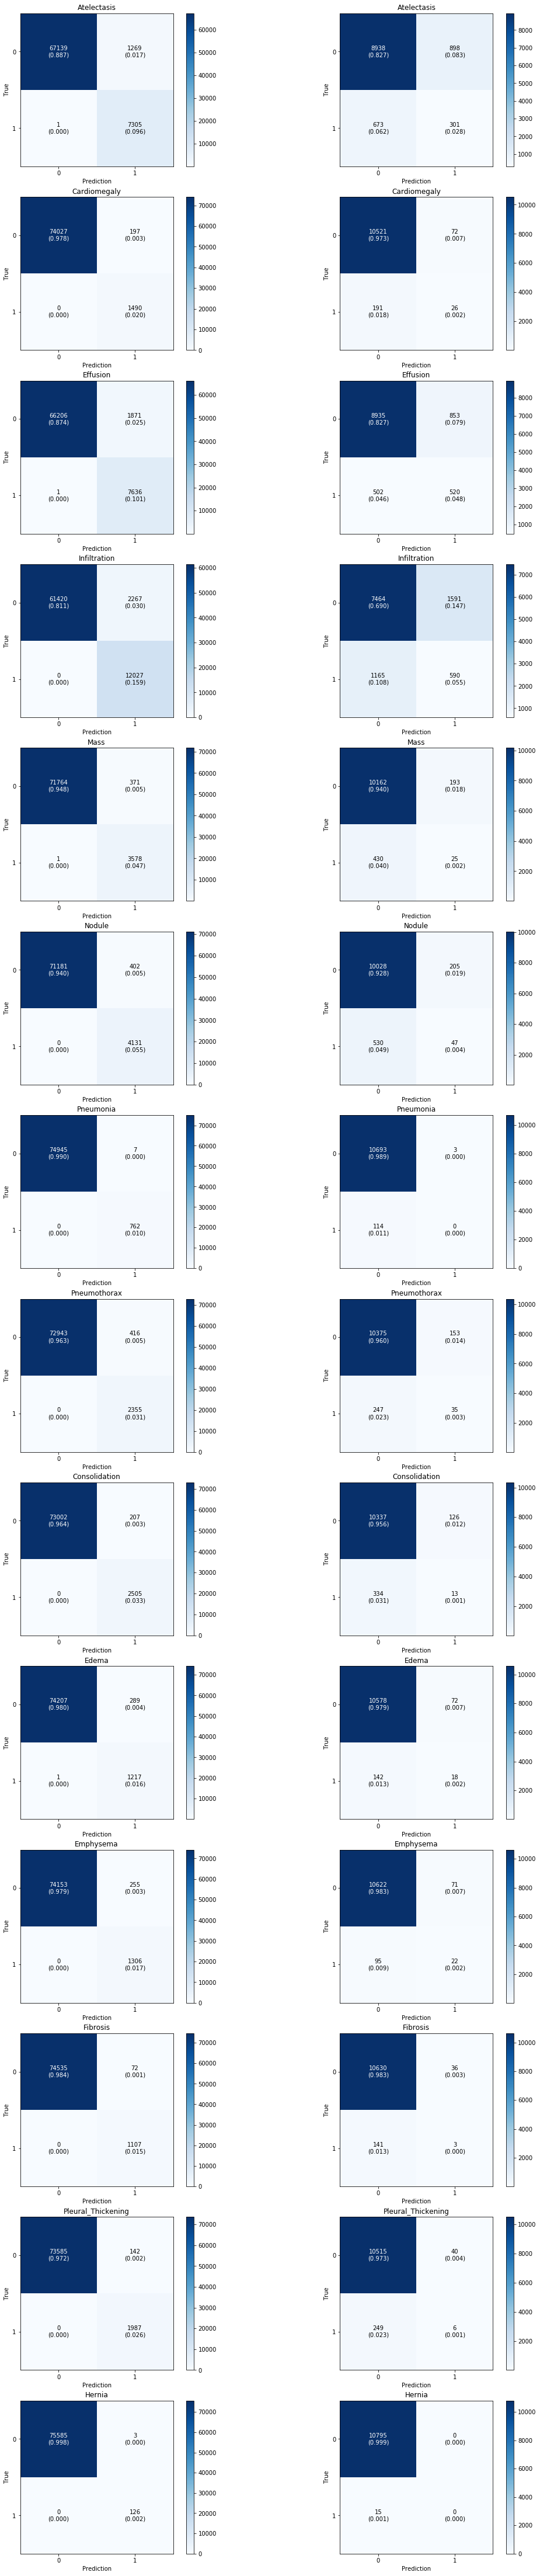

In [40]:
classes = [0, 1] # negative, positive

plt.figure(figsize=(18,80/14 * n_diseases))
plot_train_val_cms(train_cms, val_cms, classes, chosen_diseases, percentage=True)

## Add images

In [99]:
def gen_image_with_bbox(dataset, image_name, chosen_diseases):
    bboxes = []

    image, labels, _, bboxes_raw, are_valid = dataset.get_by_name(image_name)

    # Convert to batch
    images = image.view(1, *image.shape)

    # Image to GPU
    images = images.to(device)

    # Pass thru model
    with torch.no_grad():
        predictions, _, activations = model(images)

    # Copy bbox
    for disease_index, (bbox, is_valid) in enumerate(zip(bboxes_raw, are_valid)):
        is_valid = bool(is_valid.item())
        disease_name = chosen_diseases[disease_index]
        if is_valid:
            x, y, w, h = bbox.numpy()
            bboxes.append((disease_name, x, y, w, h))

    return image.numpy(), labels, predictions[0].cpu().numpy(), bboxes, activations[0].cpu().numpy()

In [100]:
image_name = "00010277_000.png"

In [101]:
image, gt, prediction, bboxes, activation = gen_image_with_bbox(dataset, image_name, chosen_diseases)
image.shape, gt.shape, prediction.shape, bboxes, activation.shape

((3, 512, 512),
 (14,),
 (14,),
 [('Effusion', 863.0, 693.0, 72.0, 112.0),
  ('Infiltration', 633.0, 416.0, 271.0, 221.0),
  ('Mass', 297.0, 310.0, 540.0, 277.0),
  ('Pneumonia', 642.0, 423.0, 265.0, 223.0)],
 (14, 16, 16))

In [102]:
image = np.interp(image, (image.min(), image.max()), (0, 1))

In [70]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np

In [71]:
colors = ["red", "blue", "cyan", "green"]

In [85]:
list(enumerate(chosen_diseases))

[(0, 'Atelectasis'),
 (1, 'Cardiomegaly'),
 (2, 'Effusion'),
 (3, 'Infiltration'),
 (4, 'Mass'),
 (5, 'Nodule'),
 (6, 'Pneumonia'),
 (7, 'Pneumothorax'),
 (8, 'Consolidation'),
 (9, 'Edema'),
 (10, 'Emphysema'),
 (11, 'Fibrosis'),
 (12, 'Pleural_Thickening'),
 (13, 'Hernia')]

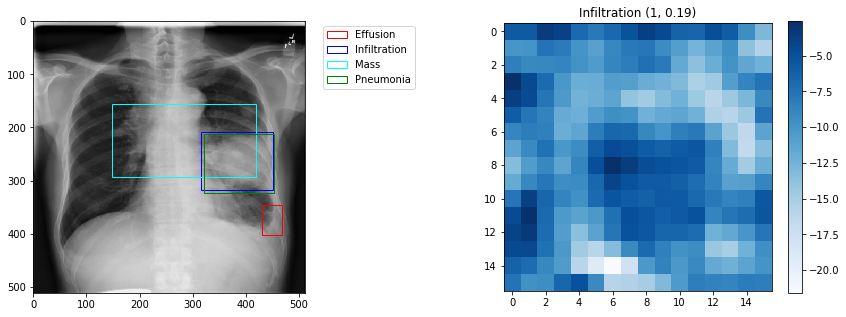

In [107]:
plt.figure(figsize=(15, 5))

plt.subplots_adjust(wspace=0.5)

plt.title(image_name)
plt.subplot(1, 2, 1)
plt.imshow(image.transpose(1, 2, 0))

scale = 2

ax = plt.gca()
for index, bbox in enumerate(bboxes):
    disease, x, y, width, height = bbox
    
    x /= scale
    y /= scale
    width /= scale
    height /= scale
    
    color = colors[index]
    rect = patches.Rectangle((x, y), width, height, linewidth=1, edgecolor=color, facecolor="none", label=disease)
    ax.add_patch(rect)

plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")

plt.subplot(1, 2, 2)
disease_index = 3
disease_name = chosen_diseases[disease_index]
pred = prediction[disease_index]

plt.title("{} ({}, {:.2f})".format(disease_name, gt[disease_index], pred))
plt.imshow(activation[disease_index], cmap="Blues")
plt.colorbar()

In [116]:
list(enumerate(gt))

[(0, 0),
 (1, 1),
 (2, 0),
 (3, 1),
 (4, 0),
 (5, 1),
 (6, 1),
 (7, 0),
 (8, 1),
 (9, 0),
 (10, 0),
 (11, 0),
 (12, 1),
 (13, 0)]

In [117]:
chosen_diseases[11]

'Fibrosis'

In [113]:
list(enumerate(prediction > 0.5))

[(0, False),
 (1, False),
 (2, False),
 (3, False),
 (4, False),
 (5, True),
 (6, False),
 (7, False),
 (8, False),
 (9, False),
 (10, False),
 (11, True),
 (12, False),
 (13, False)]

In [30]:
dataset.bbox_index.groupby("Image Index").count()["Finding Label"].sort_values(ascending=False)

Image Index
00010277_000.png    4
00018427_004.png    3
00021703_001.png    3
00012376_010.png    3
00018253_059.png    3
00013659_019.png    3
00005066_030.png    3
00008814_010.png    3
00020482_032.png    3
00010828_039.png    3
00028640_008.png    2
00028285_014.png    2
00008841_025.png    2
00003440_000.png    2
00017138_037.png    2
00002106_000.png    2
00013993_077.png    2
00013993_083.png    2
00020124_003.png    2
00020405_041.png    2
00028208_005.png    2
00020393_003.png    2
00012021_081.png    2
00017582_003.png    2
00028383_002.png    2
00020259_002.png    2
00020000_000.png    2
00025787_027.png    2
00017500_002.png    2
00009437_008.png    2
                   ..
00019124_104.png    1
00019124_090.png    1
00019124_045.png    1
00019124_006.png    1
00019646_006.png    1
00019651_002.png    1
00019706_002.png    1
00019706_012.png    1
00020318_007.png    1
00020277_001.png    1
00020274_021.png    1
00020213_078.png    1
00020184_013.png    1
00020146_005.png    

In [181]:
writer.add_images("test-images-2", all_images[:10], global_step=N_EPOCHS)

## Plot activations

In [37]:
images, labels, _, _, _ = next(iter(dataloader))
images = images.to(device)
images.size()

torch.Size([20, 3, 512, 512])

In [38]:
with torch.no_grad():
    pred, embedding, activation = model(images)

In [43]:
activation.size()

torch.Size([20, 14, 16, 16])

In [39]:
images = images.cpu()
activation = activation.cpu()

In [36]:
import matplotlib.pyplot as plt

In [51]:
labels.size()

torch.Size([20, 1])

Prediction:  0.06491883844137192
Label:  1


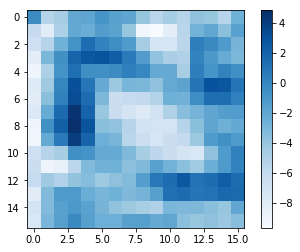

In [50]:
image_idx = 0
disease_idx = 0

prediction = pred[image_idx, disease_idx].item()
label = labels[image_idx, disease_idx].item()

plt.imshow(activation[image_idx, disease_idx], cmap="Blues")
plt.colorbar()

print("Prediction: ", prediction)
print("Label: ", label)

In [116]:
images.size()

torch.Size([4, 3, 512, 512])

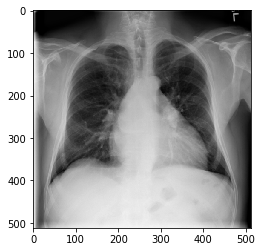

In [126]:
plt.imshow(images[image_idx][0], cmap="gray")

***
***

# Old

In [27]:
# FIXME: this code is to calculate the loss of the bbox prediction,
# though the metric should be different? don't use binary cross entropy?

#     # Get valid bbox_list
#     # REVIEW: make bbox_list a tensor? and then send to device? same on seg_list below
#     bbox_list = []
#     n_samples, n_labels = bbox_valids.size()
#     for i in range(n_samples):
#         bbox_list.append([])
#         for j in range(n_labels):
#             if bbox_valids[i][j] == 1:
#                 bbox_list[i].append(bboxes[i][j])
#         bbox_list[i] = torch.stack(bbox_list[i]).to(device)
    
    
#     # Segmentation lists
#     seg_list = []
#     for i in range(n_samples):
#         seg_list.append([])
#         for j in range(n_labels):
#             if bbox_valids[i][j] == 1:
#                 seg_list[i].append(segments[i][j])
#         seg_list[i] = torch.stack(seg_list[i]).to(device)
    
#     # Compute bbox loss
#     for i in range(len(seg_list)):
#         # REVIEW: do this with a tensor? avoid the loop
#         loss += 5/(512*512) * weighted_cross_entropy(seg_list[i], bbox_list[i], weights=(10, 1))
        
#         break
# #         print(seg_list[i].size())
# #         print(bbox_list[i].size())
# #         break